In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df4 = pd.read_csv('./widget_sales.csv') #위젯 판매량
df5 = pd.read_csv('./foot_traffic.csv') #주간 평균 이동인구
df6 = pd.read_csv('./bandwidth.csv') # 대역폭 사용량 향후 2시간 예측

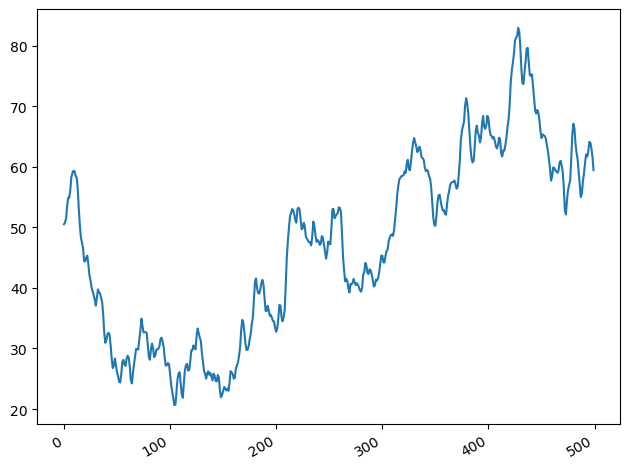

In [17]:
fig, ax = plt.subplots()

ax.plot(df4.widget_sales)

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df4['widget_sales'])

print(f'ADF statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF statistic: -1.5121662069358999
p-value: 0.5274845352272628


In [19]:
#adf 테스트 결과 비정상이니까 d 결정하기

eps_diff = np.diff(df4['widget_sales'], n=1)

ADF_result = adfuller(eps_diff)

print(f'ADF statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF statistic: -10.576657780341955
p-value: 7.076922818587346e-19


In [20]:
#모든 고유한 ARIMA(p, d, q) 모델들을 피팅하는 함수
from typing import Union
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']


    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [21]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [22]:
train = df4.widget_sales[:int(0.9*len(df4))]

result_df = optimize_ARIMA(train, order_list, d)
result_df

 88%|████████▊ | 14/16 [00:00<00:00, 34.45it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 16/16 [00:00<00:00, 21.54it/s]


,"(p,q)",AIC
0,"(3, 3)",1251.432351
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643263


/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


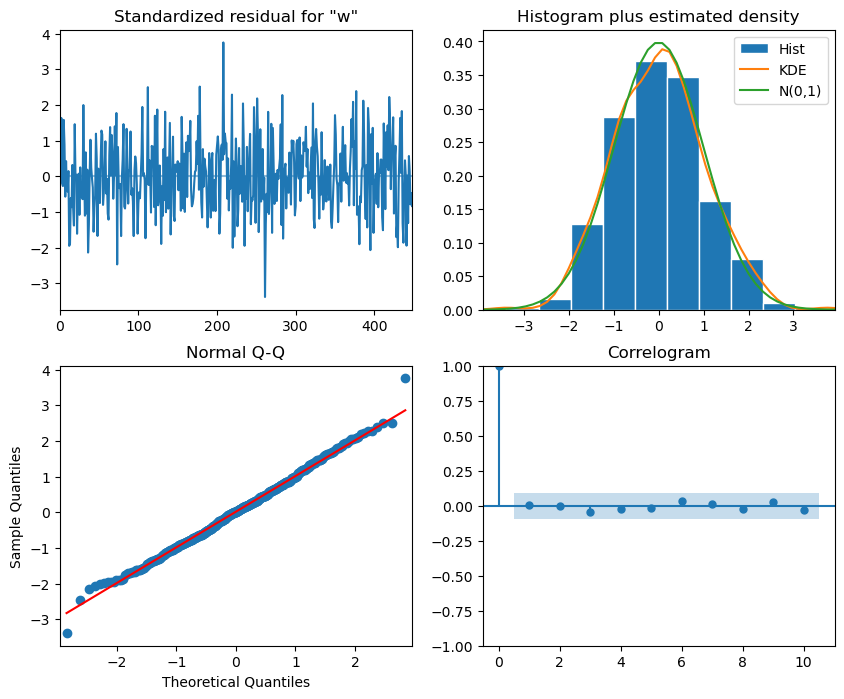

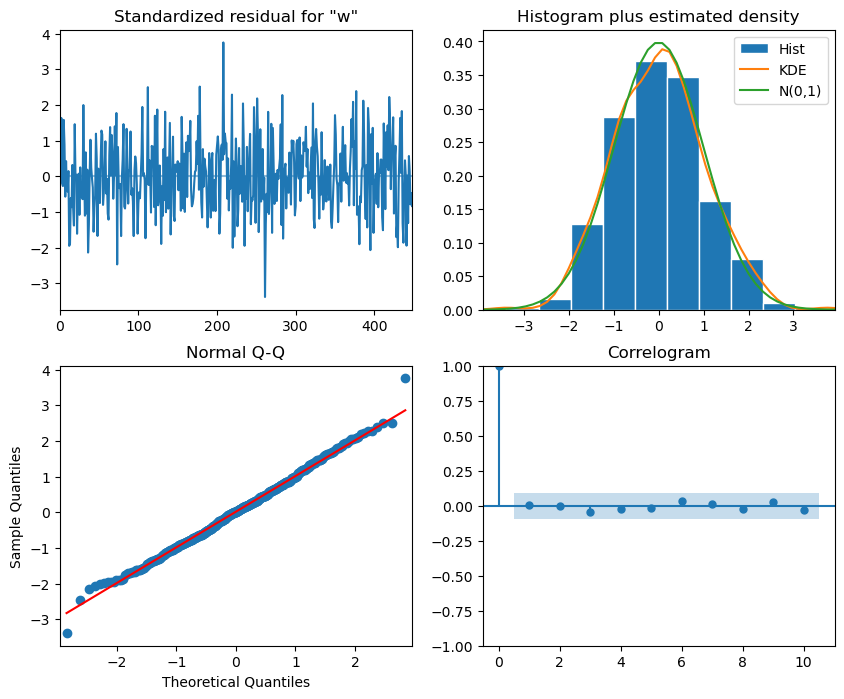

In [24]:
#q-q 도식
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

model_fit.plot_diagnostics(figsize=(10,8))

In [26]:
#정량적 테스트
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

k = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(k)

     lb_stat  lb_pvalue
1   0.017536   0.894649
2   0.045218   0.977644
3   0.241609   0.970608
4   0.263450   0.992050
5   0.283764   0.997937
6   0.704660   0.994390
7   0.828277   0.997145
8   0.903181   0.998789
9   0.953234   0.999538
10  1.003474   0.999825


In [35]:
#베이스 라인
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                    window: int, method: str) -> list:

    total_len = train_len + horizon

    #베이스라인 모델들
    if method == 'mean': #평균으로 예측
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last': #마지막 값으로 예측
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    #MA 모델
    elif method == 'ARIMA':
        pred_ARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3, 1, 3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)

        return pred_ARIMA

In [42]:
test = df4[-50:]

In [43]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2


pred_mean = rolling_forecast(df4, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df4, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df4, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/seongwoo/anaconda3/lib/python3.12/site-packages/st

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.810041
451,65.316972,45.472231,65.906136,64.714436
452,65.172070,45.558754,65.316972,66.243351
453,65.075506,45.558754,65.316972,66.611144
454,64.703173,45.644943,65.075506,64.994084


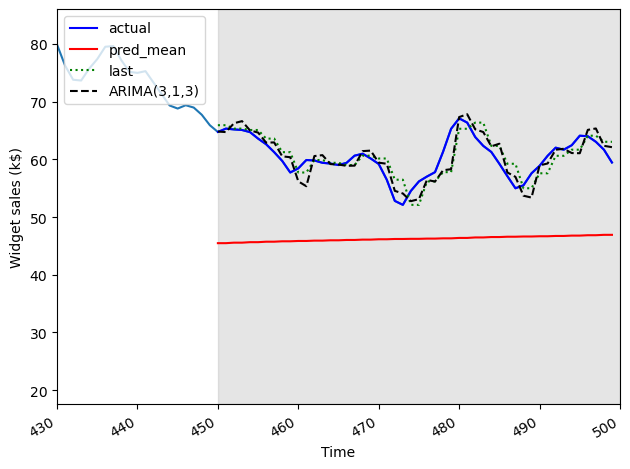

In [46]:
fig, ax = plt.subplots()

ax.plot(df4['widget_sales'])
ax.plot(test['widget_sales'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'r-', label='pred_mean')
ax.plot(test['pred_last_value'], 'g:', label='last')
ax.plot(test['pred_ARIMA'], 'k--', label='ARIMA(3,1,3)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.set_xlim(430, 500)


fig.autofmt_xdate()
plt.tight_layout()

In [47]:
from sklearn.metrics import mean_absolute_error

mean_mae = mean_absolute_error(test['widget_sales'], test['pred_mean'])
last_mae = mean_absolute_error(test['widget_sales'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['widget_sales'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

14.220336729946744 1.819226540180243 1.5733878451019188
